In [1]:
import numpy as np
import pandas as pd

# Входные данные

In [2]:
E = 7e10  # модуль Юнга
ro = 2700  # плотоность алюминия
nu = 0.33  # коэффицент Пуассона
G = E / (2 * (1 + nu))  # модуль сдвига
L = 1.5  # L1  
W = 1.5   # L2
h = 0.002   # тодщина пластины
D = (E * h ** 3) / (12 * (1 - nu ** 2))  # жесткость из уравнения колебания
N_end = 10  # расчтеные моды
M_end = 10
q1_end = 2   # число шпангаутов
q2_end = 9   # число стрингеров
h_sh = 0.1 # высота шпангоута
h_st = 0.02 # высота стрингера
b_sh_st = 0.002 # толщина сечения стрингера и шпангоута
S = N_end * M_end

# Расчет характеристик стрингеров и шпангоутов

In [3]:
S_sh = h_sh * b_sh_st  # профиль шпангоута
S_st = h_st * b_sh_st # профиль стрингера
I_sh = b_sh_st * (h_sh ** 3) / 12  # моменты инерции относительно оси y (толщина сечения)
I_st = b_sh_st * (h_st ** 3) / 12
# моменты кручения
Ik_sh = ((b_sh_st ** 3) * h_sh / 3) * (1 - 0.63 * (b_sh_st / h_sh) + 0.052 * (b_sh_st / h_sh) ** 5)
Ik_st = ((b_sh_st ** 3) * h_st / 3) * (1 - 0.63 * (b_sh_st / h_st) + 0.052 * (b_sh_st / h_st) ** 5)
# полярные моменты
Iro_sh = 0.5 * (b_sh_st * h_sh) * (h_sh ** 2 + b_sh_st ** 2)
Iro_st = 0.5 * (b_sh_st * h_st) * (h_st ** 2 + b_sh_st ** 2)
# погонные плотности шпангаутов и стрингеров (на единицу длины пластины)
ma_sh = ro * S_sh
ma_st = ro * S_st

In [4]:
# геометрия стрингеров и шпангоутов
b_pan_sh = L / (q1_end + 1) # пролет шпангаута
b_pan_st = W / (q2_end + 1) # пролет стрингера
S_pan_sh = b_pan_sh * h
S_pan_st = b_pan_st * h
V_sh = S_pan_sh * (h / 2 + h_sh / 2) / (S_pan_sh + S_sh)
V_st = S_pan_st * (h / 2 + h_st / 2) / (S_pan_st + S_st)

In [5]:
# координаты стрингеров и шпангоутов
x1 = np.arange(1, q1_end + 1) * b_pan_sh
x2 = np.arange(1, q2_end + 1) * b_pan_st

# Задаем пластину

In [6]:
# функции для вычисления ki, kj
def ku1(i):
    return (np.pi * i) / L
def ku2(j):
    return (np.pi * j) / W

In [7]:
# задаем матрицу оператора d^4/dx^4
Z0_eig = np.zeros((S, S))
for i in range(1, M_end + 1):
    for j in range(1 ,N_end + 1):
        k = (i - 1) * N_end + j
        Z0_eig[k-1][k-1] = D * (ku1(i) ** 4 + 2 * (ku1(i) * ku2(j)) ** 2 + ku2(j) ** 4)

In [8]:
# задаем массовую матрицу
Z0_eig_m = np.diag([ro * h] * S)

In [9]:
# матрицы интегралов
V1 = np.diag([L / 2] * M_end)
V2 = np.diag([W / 2] * N_end)

# Матрицы для шпангоутов

In [10]:
sh10 = np.zeros((S, S))
sh20 = np.zeros((S, S))
for m1 in range(1, M_end + 1):
    for n1 in range(1, N_end + 1):
        for m2 in range(1, M_end + 1):
            for n2 in range(1, N_end + 1):
                j1 = (m1 - 1) * N_end + n1
                j2 = (m2 - 1) * N_end + n2
                Sum_r10_1, Sum_r20_1, Sum_r10_2, Sum_r20_2 = [0] * 4
                sh10_0 = E * (I_sh + S_sh * V_sh ** 2) * ku2(n1) ** 4
                sh20_0 = G * Ik_sh * (ku1(m1) * ku2(n1)) ** 2
                for q1 in x1:
                    # упругая матрица
                    Sum_r10_1 += (4 / (L * W)) * sh10_0 * np.sin(ku1(m1) * q1) * np.sin(ku1(m2) * q1) * V2[n1-1][n2-1]
                    Sum_r10_2 += (4 / (L * W)) * sh20_0 * np.sin(ku1(m1) * q1) * np.sin(ku1(m2) * q1) * V2[n1-1][n2-1]
                    # массовая матрица
                    Sum_r20_1 += (4 / (L * W)) * ma_sh * np.sin(ku1(m1) * q1) * np.sin(ku1(m2) * q1) * V2[n1-1][n2-1]
                    Sum_r20_2 += (4 / (L * W)) * ro * Iro_sh * (ku1(m1) ** 2) * np.sin(ku1(m1) * q1) * np.sin(ku1(m2) * q1) * V2[n1-1][n2-1]
                    
                sh10[j1-1][j2-1] = Sum_r10_1 + Sum_r10_2  # упругая
                sh20[j1-1][j2-1] = Sum_r20_1 + Sum_r20_2  # массовая

# Матрицы для стрингеров

In [11]:
st10 = np.zeros((S, S))
st20 = np.zeros((S, S))
for m1 in range(1, M_end + 1):
    for m2 in range(1, M_end + 1):
        for n1 in range(1, N_end + 1):
            for n2 in range(1, N_end + 1):
                j1 = (m1 - 1) * N_end + n1
                j2 = (m2 - 1) * N_end + n2
                Sum_r10_1, Sum_r20_1, Sum_r10_2, Sum_r20_2 = [0] * 4
                st10_0 = E * (I_st + S_st * V_st ** 2) * ku1(m1) ** 4
                st20_0 = G * Ik_st * (ku1(m1) * ku2(n1)) ** 2
                for q2 in x2:
                    # упругая матрица
                    Sum_r10_1 += (4 / (L * W)) * st10_0 * np.sin(ku2(n1) * q2) * np.sin(ku2(n2) * q2) * V1[m1-1][m2-1]
                    Sum_r10_2 += (4 / (L * W)) * st20_0 * np.sin(ku2(n1) * q2) * np.sin(ku2(n2) * q2) * V1[m1-1][m2-1]
                    # массовая матрица
                    Sum_r20_1 += (4 / (L * W)) * ma_st * np.sin(ku2(n1) * q2) * np.sin(ku2(n2) * q2) * V1[m1-1][m2-1]
                    Sum_r20_2 += (4 / (L * W)) * ro * Iro_st * (ku2(n1) ** 2) * np.sin(ku2(n1) * q2) * np.sin(ku2(n2) * q2) * V1[m1-1][m2-1]
                    
                st10[j1-1][j2-1] = Sum_r10_1 + Sum_r10_2  # упругая
                st20[j1-1][j2-1] = Sum_r20_1 + Sum_r20_2  # массовая

In [12]:
# упругая суммарная
Z0_eig_1 = Z0_eig + sh10 + st10
# массовая суммарная
Z0_eig_2 = Z0_eig_m + sh20 + st20

In [13]:
# финальная матрица
Z0_eig_final = np.linalg.inv(Z0_eig_2).T @ Z0_eig_1

In [14]:
# считаем собственные частоты
A, B = np.linalg.eig(Z0_eig_final)
eig_f = np.sqrt(np.sort(A)).reshape(N_end, M_end)
pd.DataFrame(eig_f / (np.pi * 2))

,0,1,2,3,4,5,6,7,8,9
0,70.488533,84.990648,125.614234,126.808919,129.419330,134.292034,142.417488,153.045492,154.722907,162.499651
1,167.663619,171.884541,174.691036,185.137756,194.249968,199.530694,199.933182,212.323858,219.673651,221.884600
2,232.221777,236.977517,238.622967,240.271666,243.456027,244.657579,246.590710,254.782493,266.219960,281.779110
3,295.678370,302.073854,303.429199,316.141186,317.078850,384.973130,393.513125,407.820581,425.556073,501.422229
4,502.378394,504.131978,506.918847,511.060092,516.951012,525.044926,535.831465,549.810183,562.065167,579.013031
5,585.665327,591.896217,599.516493,609.333611,616.004185,621.937695,641.384314,650.879226,702.439138,714.145712
6,721.290268,728.505566,737.187162,748.077441,767.596939,785.899635,946.679951,987.066465,1127.786851,1128.611448
7,1130.057044,1132.229718,1135.276263,1139.382267,1144.769408,1151.691811,1160.431343,1247.970808,1248.765824,1250.460618
8,1251.267101,1254.397932,1258.214860,1263.163870,1269.505335,1277.506414,1604.657522,1616.725126,2479.311929,2488.036472
9,3555.592707,3564.918906,4829.967300,4841.372197,6300.877241,6315.421358,7967.320677,7986.017776,10117.563254,10187.135897


In [15]:
idx = A.argsort()   
A = A[idx]
B = B[:,idx]

# Рисуем решение

In [37]:
x = np.linspace(0, L, 1000)
y = np.linspace(0, W, 1000)
xx, yy = np.meshgrid(x, y)

In [38]:
mode = 2
w = np.sqrt(A[mode - 1]) / (np.pi * 2)

In [39]:
b = B[:, mode-1] # eigen vector

In [40]:
s = lambda i, j: (i - 1) * N_end + j - 1
zz= np.array([[b[s(i, j)] * np.sin(ku1(i) * xx) * np.sin(ku2(j) * yy) for i in range(1, M_end + 1)] for j in range(1, N_end + 1)])

In [41]:
zz = np.sum(zz, (0, 1))

<IPython.core.display.Javascript object>


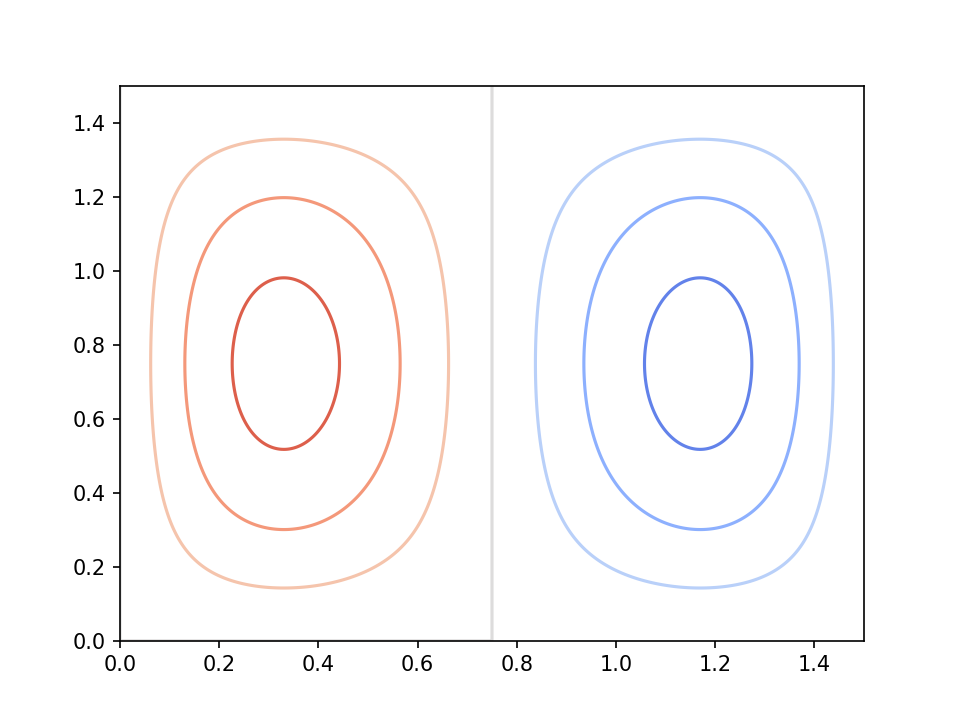

In [42]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib notebook
# Рисуем моду
fig = plt.figure()
ax = fig.add_subplot(111)
ax.contour(xx, yy, zz * (-1), cmap=cm.coolwarm)

In [23]:
# visualisation
fps = 10 # frame per sec
frn = 50 # frame number of the animation

In [26]:
t = np.linspace(0, 4 * np.pi / w, frn)
z_arr = np.array([zz * np.cos(w * i + np.pi / 2) for i in t])

In [27]:
def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plot[0] = ax.plot_surface(xx, yy, zarray[frame_number], cmap="magma")

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plot = [ax.plot_surface(xx, yy, z_arr[0], color='0.75', rstride=1, cstride=1)]
ax.set_zlim(0,1.1)
ani = animation.FuncAnimation(fig, update_plot, frn, fargs=(z_arr, plot), interval=1000/fps)

<IPython.core.display.Javascript object>

NameError: name 'animation' is not defined

In [39]:
fn = '3x4mode'
ani.save(fn+'.gif',writer='imagemagick',fps=fps)